# Logistic regression - L5

In [168]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("../data/Default.csv")


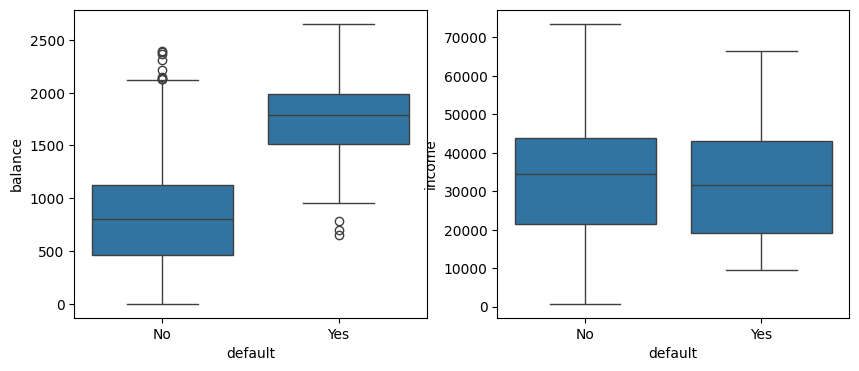

In [169]:
fig, ax = plt.subplots(1, 2, dpi=100, figsize = (10,4))

for axe, col in zip(ax, ["balance", "income"]):
    sns.boxplot(data=df, x="default", y=col, ax=axe)

Kom ihåg att boxplots jämför med normalfördelning. Sen är det ju kategoriska värden och det kan ju datorn inte göra något med på detta sätt.  

In [170]:
# dummy encoding
df_de = pd.get_dummies(df, columns = ["default", "student"], drop_first=True)
display(df_de.head())

# one-hot encoding
df_ohe = pd.get_dummies(df, columns = ["default", "student"])
display(df_ohe.head())

,balance,income,default_Yes,student_Yes
0,729.526495,44361.625074,False,False
1,817.180407,12106.134700,False,True
2,1073.549164,31767.138947,False,False
3,529.250605,35704.493935,False,False
4,785.655883,38463.495879,False,False


,balance,income,default_No,default_Yes,student_No,student_Yes
0,729.526495,44361.625074,True,False,True,False
1,817.180407,12106.134700,True,False,False,True
2,1073.549164,31767.138947,True,False,True,False
3,529.250605,35704.493935,True,False,True,False
4,785.655883,38463.495879,True,False,True,False


**Dummy encoding** då har vi bara en kolumn där det står t ex 0 eller 1. I vårt fall kan vi lämpligt göra dem till ettor och nollor. Booleans fungerar också. Om vi har ett mer komplext fall om vi har flera eller inga kategorier samtidigt, då behöver vi **one-hot encoding**. Då exanderar vi så att vi får fler kolumner och det kan stå t ex noll eller ett på båda.  

Nu modellerar vi sannolikheten att vi tillhör en viss klass. Det fungerar hyfsat att köra en regression med X och b som en linjär modell. Det är dock inte säkert att variablerna summerar till ett (som en sannolikhet ska). Dessutom anser vi att det finns en numerisk relation mellan True och False. True blir ju större vilket blir konstigt. Tänk låg, medel, hög. Då kanske två medel skulle vara lika med en hög men tänk färger och andra fall så blir det konstigt.  

Vi vill att det ska vara en sannolikhetsfördelning. 

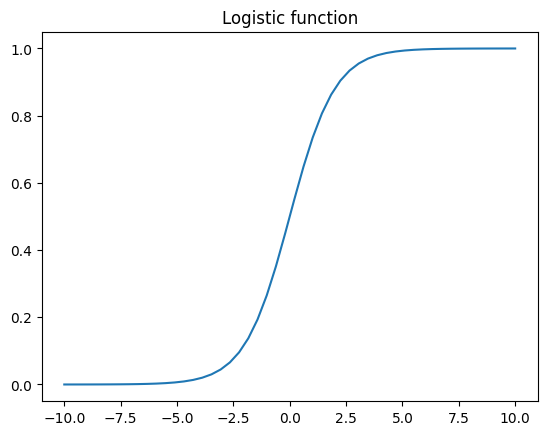

In [171]:
import numpy as np

logistic_function = lambda x: np.exp(x)/(1+np.exp(x))

x = np.linspace(-10, 10)
plt.plot(x, logistic_function(x))
plt.title("Logistic function"); 
# values are constrained to 0 and 1, S-shaped curve

En sigmoidkurva som går från noll till ett. Det verkar lovande! Vi kan alltså använda den här funktionen. Sigmoidurvor är bra när vi har med sannolikheter att göra.  

e^X är sin egen derivata. Du kan säga att det är en bas för alla exponenta rum ... .  

Om vi nu försöker modellera på denna funktionen direkt nu så blir det svårt, vi har ju x i både nämnade och täljare. Vi kommer att använda odds, som används när en tävlar på hästar. En siffra från noll till oändligheten och ju större desto högre sannolikhet. Vi behöver alltså logaritmisera båda sidor och får "logit odds" som det brukar kallas:  

$$l(\beta_0, \beta_1) = \prod_{y_i = 1}p(x_i)\prod_{y_j=0}(1-p(x_j))$$  

"Logaritmen av oddsen att tillhöra en viss klass." Modellen är linjär i X men en vanlig linjär modell så får vi problem med att vi kan få t ex negativa sannolikheter - vad betyder det? Nu har vi gjort en feature-förändring och då fungerar inte OLS längre. Att minimera kvadraten betyder inget längre. Nu använder vi i stället maximum likelihood.  

[en förklaring till båda $\prod$ i ovan]  

Vi försöker hitta max i stället för min, så att säga. Vi kommer använda SGD för att lösa denna tvåpunktsfördelning (True, False).  

In [172]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = df_de.drop("default_Yes", axis=1), df_de["default_Yes"] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

model = LogisticRegression(penalty=None)
model.fit(scaled_X_train, y_train)
model.coef_, model.intercept_

(array([[ 2.88848257,  0.00619039, -0.29011374]]), array([-6.36187634]))

Nu måste vi skalera eftersom värdena ska vara mellan noll och ett. Vi vill inte att de ska ha olika verkan, parametrarna hade fått olika vikter som vi inte vet.  

Som vi ser får vi ut någon sorts modell med koefficienter (3 st) och intercept (1 st). Det är fortfarande en linjär modell men vi har förvandlat feature-rymden till en punktdistribution.  

In [173]:
test_sample = pd.DataFrame({"balance": [1500, 1500], "income": [
                           40000, 40000], "student_Yes": [1, 0]})

print(test_sample)
# only difference is that one is student and the other is not
scaled_test_sample = scaler.transform(test_sample)

# first column is -1 label i.e. not default, second column is label 1 i.e. default
model.predict_proba(scaled_test_sample)
# we see that being student decreases the chance of getting default 

   balance  income  student_Yes
0     1500   40000            1
1     1500   40000            0


array([[0.94488091, 0.05511909],
       [0.90077997, 0.09922003]])

Det här är bara lite påhittad data, jämnt fördelad som vi ser.  

Vi fick koefficienter för varje rad.  

[NU SA RAPHAEL NÅGOT VIKTIGT OM RESULTATET SOM JAG MISSADE]  

In [174]:
y_pred_probability = model.predict_proba(scaled_X_test)
y_pred_probability[:5]

array([[9.30371604e-01, 6.96283964e-02],
       [9.98550654e-01, 1.44934591e-03],
       [9.99985392e-01, 1.46075512e-05],
       [9.99971155e-01, 2.88449734e-05],
       [9.54564556e-01, 4.54354445e-02]])

Ganska små sannolikheter i detta fallet. Vi behöver dock evaluera detta på något sätt.  

Random comment: Cross-validation med k-fold vill vi nästan alltid göra med obalanserad data. Det är krävande för prestanda men vi vinner mycket på att göra det. 

### rast

Accuracy kan ju bli högt bara för att vi inte har så många av det ena värdet. Problem vid obalanserad data.  
Precision  - om vi vill undvika false positives.  
Recall - om vi vill undvika false negatives.  
F1 - om både precision och recall är höga får vi ett högt och bra tal. 

Accuracy: 0.973


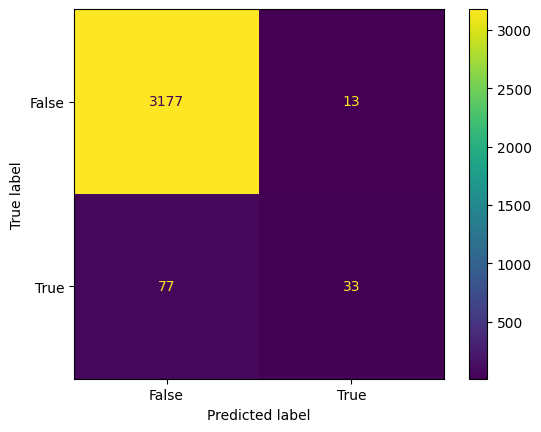

In [175]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report

y_pred = model.predict(scaled_X_test)
acc = accuracy_score(y_test, y_pred)
# note that the accuracy is very high, which is because of the accuracy paradox as the data is highly imbalanced. 
# this means that we could make a model that always classifies negative on default, and achieve very high accuracy
print(f"Accuracy: {acc:.3f}")
cm = confusion_matrix(y_test, y_pred, labels = model.classes_)

disp = ConfusionMatrixDisplay(cm, display_labels = model.classes_)
disp.plot()

In [176]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.98      1.00      0.99      3190
        True       0.72      0.30      0.42       110

    accuracy                           0.97      3300
   macro avg       0.85      0.65      0.70      3300
weighted avg       0.97      0.97      0.97      3300



Obalanserat så accuracy är inte mest pålitligt. F1-score på True får vi lågt av pga få fall och framförallt recall.  

Det är ganska vanligt i verkligheten att vi har få negativa exempel. Hur vi tacklar det beror tyvärr på det specifika problemet. Går det att balansera genom att slänga data för att få lika många av varje? Men om det är viktigt att det finns flest negativa så blir det ju fel. Ett sätt att komma runt detta är KNN.  

# KNN - L6

KNN lär sig inget utan håller bara reda på dataset. "Ta det som mest liknar vårt tidigare exempel" Fungerar för regression och klassificering. Det finns en unsupervised också. 

In [177]:
from sklearn.datasets import load_wine
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

wine = load_wine()
df = pd.DataFrame(wine.data, columns = wine.feature_names)
df = pd.concat([df, pd.DataFrame(wine.target, columns = ["wine_class"])], axis = 1)
display(df.head())

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,wine_class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


Enligt en heatmap ser det ut som att favanoider har många korrelationer så de olika vill vi ha med. Utan att prata med en kemist så är det svårt att veta vad vi kan ta bort. Det finns linjära beroenden i data i alla fall så de är inte helt separerbara. 

Här det svårt för oss att avgöra vad alla värden betyder så vi vill normalisera. Det finns dock en risk, vad skulle det t ex betyda att hälften av värdena blir negativa? 

#### rast

### NOTE: det som står i L6 gällande elbow är FEL. Vi ska göra såhär: 

## Pipeline and GridsearchCV

In [178]:
wine = load_wine()
print(wine.keys())
print(wine.feature_names)
print(wine.target_names)

df = pd.DataFrame(wine.data, columns = wine.feature_names)
df = pd.concat([df, pd.DataFrame(wine.target, columns = ["wine_class"])], axis = 1)
df.head()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names'])
['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
['class_0' 'class_1' 'class_2']


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,wine_class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [179]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

X, y = df.drop("wine_class", axis = "columns"), df["wine_class"]
# want to have somewhat larger test set for evaluation metrics later
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

scaler = MinMaxScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

model_KNN = KNeighborsClassifier(n_neighbors=1)

model_KNN.fit(scaled_X_train, y_train)

y_pred = model_KNN.predict(scaled_X_test)
y_pred

array([0, 0, 2, 0, 1, 0, 1, 2, 1, 2, 0, 2, 0, 2, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 2, 2, 2, 1, 0, 1, 0, 0, 1, 2, 0, 0, 0, 2, 2, 1, 2, 0, 1, 1, 1,
       2, 0, 1, 1, 2, 0, 1, 0, 0, 2, 2, 1, 1, 0, 1, 0, 2, 1, 0, 2, 0, 0,
       0, 2, 0, 0, 1, 2, 1, 0, 2, 0, 0, 2, 1, 1, 0, 2, 0, 0, 1, 0, 0, 2,
       1])

Vi ska använda cross-validation. KNN har det inte inbyggt. Vi ska även jämföra via softmax (detta återkommer vi till).  

Gridsearch är en form av hyperparameteroptimering. 

In [180]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np

scaler = StandardScaler()

# bygg pipeline
pipe_log = Pipeline([("scaler", scaler), ("log", LogisticRegression(
    solver="saga", max_iter=1000, penalty="elasticnet"))])
pipe_KNN = Pipeline([("scaler", scaler), ("knn", KNeighborsClassifier())])

# parametrar för hyperparameteroptimering
param_grid_KNN = {"knn__n_neighbors": list(range(1,50))}

l1_ratio = np.linspace(0, 1, 20)
param_grid_log = {"log__l1_ratio": l1_ratio}

classifier_KNN = GridSearchCV(estimator=pipe_KNN, param_grid=param_grid_KNN, cv=5, scoring="accuracy")
classifier_log = GridSearchCV(estimator=pipe_log, param_grid=param_grid_log, cv=5, scoring="accuracy")

classifier_KNN.fit(X_train, y_train)
classifier_log.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('log',
                                        LogisticRegression(max_iter=1000,
                                                           penalty='elasticnet',
                                                           solver='saga'))]),
             param_grid={'log__l1_ratio': array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])},
             scoring='accuracy')

In [181]:
classifier_KNN.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()), ('knn', KNeighborsClassifier())],
 'transform_input': None,
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 5,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [182]:
classifier_log.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('log',
   LogisticRegression(l1_ratio=np.float64(0.3157894736842105), max_iter=1000,
                      penalty='elasticnet', solver='saga'))],
 'transform_input': None,
 'verbose': False,
 'scaler': StandardScaler(),
 'log': LogisticRegression(l1_ratio=np.float64(0.3157894736842105), max_iter=1000,
                    penalty='elasticnet', solver='saga'),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'log__C': 1.0,
 'log__class_weight': None,
 'log__dual': False,
 'log__fit_intercept': True,
 'log__intercept_scaling': 1,
 'log__l1_ratio': np.float64(0.3157894736842105),
 'log__max_iter': 1000,
 'log__multi_class': 'deprecated',
 'log__n_jobs': None,
 'log__penalty': 'elasticnet',
 'log__random_state': None,
 'log__solver': 'saga',
 'log__tol': 0.0001,
 'log__verbose': 0,
 'log__warm_start': False}

              precision    recall  f1-score   support

           0       0.89      1.00      0.94        33
           1       1.00      0.85      0.92        34
           2       0.96      1.00      0.98        22

    accuracy                           0.94        89
   macro avg       0.95      0.95      0.95        89
weighted avg       0.95      0.94      0.94        89



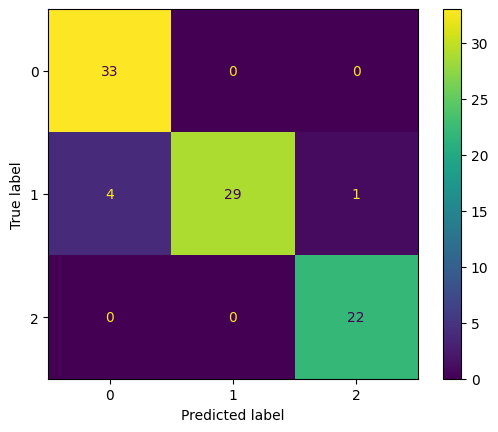

In [183]:
y_pred_KNN = classifier_KNN.predict(X_test)
print(classification_report(y_test, y_pred_KNN))
cm_KNN = confusion_matrix(y_test, y_pred_KNN)
ConfusionMatrixDisplay(cm_KNN).plot()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        34
           2       1.00      1.00      1.00        22

    accuracy                           1.00        89
   macro avg       1.00      1.00      1.00        89
weighted avg       1.00      1.00      1.00        89



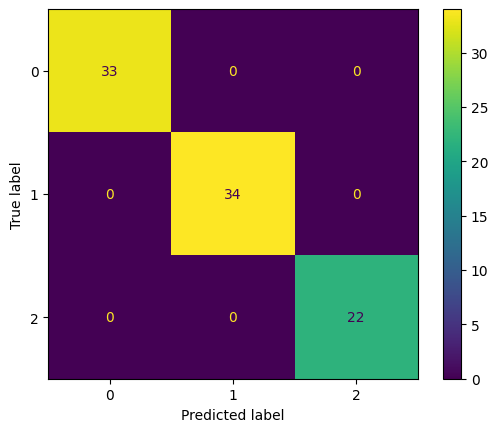

In [184]:
y_pred_log = classifier_log.predict(X_test)
print(classification_report(y_test, y_pred_log))
cm_log = confusion_matrix(y_test, y_pred_log)
ConfusionMatrixDisplay(cm_log).plot()

Logit odds gör att vi får tillräckligt många dimensioner för att särskilja dem och få ett perfekt resultat. 